In [1]:
import pandas as pd
import pickle
import sys
import matplotlib.pyplot as plt
sys.path.append("../code/")
out_overall = pickle.load(open('../data/input/all_regions.pkl', 'r'))
from common_functions import tableau20blind, format_axes, latexify
from regional_average_contribution import contribution

In [2]:
%matplotlib inline

In [3]:
def get_kdd(appliance, feature):
    base_path = "/Users/nipunbatra/output/unified/kdd_all_features_cv/"
    m = {}
    sem = {}
    for num_homes in range(4, 40, 2):
        try:
            m[num_homes]={}
            out = pickle.load(open("%s%s_%d_0_25_%s.pkl" %(base_path, appliance, num_homes, feature),'r'))
            for i in range(0, 25):
                m[num_homes][i] = out[i].median().mean()
                #sem[num_homes][i] = out[i].median().sem()
        except Exception, e:
            pass
        sem[num_homes] = (pd.Series(m[num_homes])).sem()
        m[num_homes] = pd.Series(m[num_homes]).mean()
    return pd.Series(m), pd.Series(sem)

In [4]:
def get_kdd_percentage(appliance, feature):
    base_path = "/Users/nipunbatra/output/unified/kdd_all_features_cv_percentage/"
    m = {}
    sem = {}
    for num_homes in range(4, 40, 2):
        try:
            m[num_homes]={}
            out = pickle.load(open("%sAustin_%s_%d_0_25_%s.pkl" %(base_path, appliance, num_homes, feature),'r'))
            for i in range(0, 25):
                m[num_homes][i] = out[i].median().mean()
                #sem[num_homes][i] = out[i].median().sem()
        except Exception, e:
            pass
        sem[num_homes] = (pd.Series(m[num_homes])).sem()
        m[num_homes] = pd.Series(m[num_homes]).mean()
    return pd.Series(m), pd.Series(sem)

In [5]:
def get_ubicomp(appliance, transform):

    base_path = "/Users/nipunbatra/output/unified/unified_all_features_cv/"
    m = {}
    sem = {}
    for num_homes in range(4, 40, 2):
        try:
            m[num_homes]={}
            out = pickle.load(open("%s%s_%d_10_%s_3.pkl" %(base_path, appliance, num_homes, transform),'r'))
            for trial in range(0, 5):
                m[num_homes][trial] = pd.concat([pd.DataFrame(out[i][trial]).T for i in range(0,5)]).median().mean()
                #sem[num_homes][i] = out[i].median().sem()
        except Exception, e:
            print e
        sem[num_homes] = (pd.Series(m[num_homes])).sem()
        m[num_homes] = pd.Series(m[num_homes]).mean()*100
        
    return pd.Series(m), pd.Series(sem)
        #sem[num_homes] = pd.Series(m[num_homes])

In [6]:
def get_fhmm(appliance):
    count = 0
    for test_region in ["Austin"]:
        out = {}
        test_df = out_overall[test_region]
        test_df=test_df[(test_df.full_agg_available==1)&(test_df.md_available==1)]
        
        if appliance=="hvac":
            start, stop=5, 11
        else:
            start, stop=1, 13
        out[appliance] = {}
        test_df_appliance=test_df.ix[test_df[['%s_%d' %(appliance,month) for month in range(start,stop)]].dropna().index]
        for test_home in test_df_appliance.index:
            pred_df = pd.read_csv("/Users/nipunbatra/wiki-15min-fhmm-out/%s_%d.csv" %(test_region, test_home),index_col=0)
            pred_df_appliance = pred_df[appliance].ix[start:stop-1]
            gt_df_appliance = test_df.ix[test_home][['%s_%d' %(appliance, month) for month in range(start, stop)]]
            gt_df_appliance.index = pred_df_appliance.index
            error = ((pred_df_appliance-gt_df_appliance).abs()*100/gt_df_appliance)
            #error[error>100]=100
            #acc = 100-error
            out[appliance][test_home]=error
    return pd.DataFrame(out[appliance]).T.median().mean()

In [7]:
def get_regional_average(appliance, test_region='Austin'):
    contri_austin_appliance = contribution[test_region]['Cooling'][appliance]
    if appliance=="hvac":
        start, stop=5, 11
    else:
        start, stop=1, 13
    test_df = out_overall[test_region]
    test_df=test_df[(test_df.full_agg_available==1)&(test_df.md_available==1)]
        
    test_df_appliance=test_df.ix[test_df[['%s_%d' %(appliance,month) for month in range(start,stop)]].dropna().index]
    pred_df = test_df_appliance[['aggregate_%d' %month for month in range(start, stop)]]*contri_austin_appliance
    gt_df = test_df_appliance[['%s_%d' %(appliance, month) for month in range(start, stop)]]
    gt_df.columns = pred_df.columns
    error = (gt_df-pred_df).abs().div(gt_df).mul(100)
    return error.median().mean()

In [8]:
def get_lbm(appliance, region):
    if appliance=="hvac":
        start, stop=5, 11
    else:
        start, stop=1, 13
    test_df = out_overall[test_region]
    test_df=test_df[(test_df.full_agg_available==1)&(test_df.md_available==1)]
    pred_df = lbm_pred_df[['%s_%d' %(appliance,month) for month in range(start,stop)]]

    test_df_appliance=test_df.ix[test_df[['%s_%d' %(appliance,month) for month in range(start,stop)]].dropna().index]
    gt_df = test_df_appliance[['%s_%d' %(appliance, month) for month in range(start, stop)]]
    gt_df.columns = pred_df.columns
    error = (gt_df-pred_df).abs().div(gt_df).mul(100)
    return error.median().mean()

In [9]:
params = {
    'hvac':
        {'ubicomp':'DD-percentage',
        'kdd':'Monthly+Static'},
    'fridge':
    {'ubicomp':'regional-average',
    'kdd':'Monthly+Static'}
}

for appliance in ['dw','mw','oven','wm']:
    params[appliance] = {'ubicomp':'None','kdd':'Monthly+Static'}

In [10]:
appliance ='mw'
get_kdd(appliance,'Monthly').plot(label='M')
get_kdd(appliance,'Monthly+Static').plot(label='M+S')
get_kdd(appliance,'Static').plot(label='S')

plt.legend()

AttributeError: 'tuple' object has no attribute 'plot'

In [11]:
latexify()

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [12]:
appliance='fridge'
ubicomp_df = get_ubicomp(appliance,params[appliance]['ubicomp'])

In [13]:
sem

NameError: name 'sem' is not defined

In [136]:
a, b = get_kdd('hvac',params['hvac']['kdd'])

In [137]:
a

4     39.260076
6     35.458107
8     32.286633
10    30.805677
12    30.102990
14    28.978034
16    28.619796
18    27.452863
20    26.861122
22    26.656261
24    26.402000
26    25.919532
28    26.456479
30    25.515530
32    26.074989
34    24.860589
36    25.033520
38    24.906131
dtype: float64

In [138]:
b

4     78.233231
6     54.993228
8     62.687639
10    44.674267
12    36.400330
14    47.342837
16    39.172538
18    41.392421
20    39.158330
22    27.688825
24    27.142222
26    22.860158
28    25.880883
30    39.293593
32    37.506018
34    25.973739
36    28.707209
38    30.792360
dtype: float64

In [102]:
kdd_df = get_kdd_percentage('hvac',params['hvac']['kdd'])
print kdd_df

kdd_df = get_kdd('hvac',params['hvac']['kdd'])
print kdd_df

4     25.538918
6     25.543330
8     26.165342
10    23.708423
12    23.468754
14    23.105561
16    23.050981
18    22.828006
20    24.320804
22    23.497307
24    23.505640
26    24.019886
28    22.932350
30    22.666073
32    23.756689
34    23.911262
36    23.401322
38    24.063306
dtype: float64
4     39.260076
6     35.458107
8     32.286633
10    30.805677
12    30.102990
14    28.978034
16    28.619796
18    27.452863
20    26.861122
22    26.656261
24    26.402000
26    25.919532
28    26.456479
30    25.515530
32    26.074989
34    24.860589
36    25.033520
38    24.906131
dtype: float64


hvac
fridge
wm
mw
'mw'
dw
oven
[Errno 2] No such file or directory: '/Users/nipunbatra/output/unified/unified_all_features_cv/oven_26_10_None_3.pkl'
[Errno 2] No such file or directory: '/Users/nipunbatra/output/unified/unified_all_features_cv/oven_28_10_None_3.pkl'
[Errno 2] No such file or directory: '/Users/nipunbatra/output/unified/unified_all_features_cv/oven_30_10_None_3.pkl'
[Errno 2] No such file or directory: '/Users/nipunbatra/output/unified/unified_all_features_cv/oven_32_10_None_3.pkl'
[Errno 2] No such file or directory: '/Users/nipunbatra/output/unified/unified_all_features_cv/oven_34_10_None_3.pkl'
[Errno 2] No such file or directory: '/Users/nipunbatra/output/unified/unified_all_features_cv/oven_36_10_None_3.pkl'
[Errno 2] No such file or directory: '/Users/nipunbatra/output/unified/unified_all_features_cv/oven_38_10_None_3.pkl'
'oven'


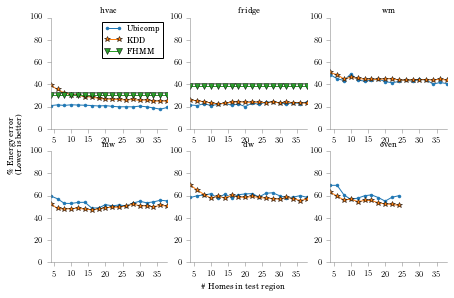

In [15]:
appliances = ["hvac","fridge","wm","mw","dw","oven"]
latexify(columns=2)
nrows=2
ncols=3
fig, ax = plt.subplots(nrows=2, ncols=3)
for i, appliance in enumerate(appliances):
    print appliance
    x = i/ncols
    y = i%ncols
    ubicomp_df, ubicomp_err_df = get_ubicomp(appliance,params[appliance]['ubicomp']) 
    #ubicomp_df.plot(label="Ubicomp", color=tableau20blind[0],ax = ax[x,y], yerr=ubicomp_err_df)
    ubicomp_df.plot(label="Ubicomp", color=tableau20blind[0],ax = ax[x,y], marker='.')
    kdd_df, kdd_err = get_kdd(appliance,params[appliance]['kdd'])
    """
    
    if appliance=="hvac":
        kdd_df = get_kdd_percentage('hvac',params['hvac']['kdd'])

    else:
        kdd_df = get_kdd(appliance,params[appliance]['kdd'])
    """
    kdd_df.plot(label="KDD",color=tableau20blind[2], ax=ax[x,y], marker='*')
    #kdd_df.plot(label="KDD",color=tableau20blind[2], ax=ax[x,y], yerr=kdd_err)
    fhmm_val = get_fhmm(appliance)
    fhmm_ser = pd.Series(fhmm_val, index=kdd_df.index)
    
    fhmm_ser.plot(label="FHMM",color=tableau20blind[4], ax=ax[x,y],marker='v')
    try:
        regional_average_val = get_regional_average(appliance)
        regional_average_ser = pd.Series(regional_average_val, index=kdd_df.index)
        #regional_average_ser.plot(label="Regional average",color=tableau20blind[6], ax=ax[x,y])
    except Exception, e:
        print e

    #plt.ylabel("\% Error in energy\n(lower is better)")
    #plt.xlabel("\#homes in test region")
    #plt.legend()
    #plt.tight_layout()
    format_axes(ax[x,y])
    ax[x,y].set_title(appliance)
    ax[x,y].set_ylim((0, 100))
ax[0,0].legend( )
#loc = 'upper center', bbox_to_anchor = (0,-0.1,1,1),
#            bbox_transform = plt.gcf().transFigure

#fig.tight_layout()
fig.text(0.5, 0.04, '\# Homes in test region', ha='center')
fig.text(0.04, 0.5, '\% Energy error \n(Lower is better)', va='center', rotation='vertical')

plt.savefig("/Users/nipunbatra/Desktop/result_buildsys.pdf",bbox_inches="tight")
plt.savefig("/Users/nipunbatra/Desktop/result_buildsys.png",bbox_inches="tight")


In [21]:
appliance_name_map = {
    'hvac':'HVAC',
    'fridge':'Fridge',
    'wm':'Washing\nmachine',
    'mw':'Microwave',
    'dw':'Dish\nwasher',
    'oven':'Oven'
}


hvac
fridge
wm
mw
'mw'
dw
oven
'oven'
[Errno 2] No such file or directory: '/Users/nipunbatra/output/unified/unified_all_features_cv/oven_26_10_None_3.pkl'
[Errno 2] No such file or directory: '/Users/nipunbatra/output/unified/unified_all_features_cv/oven_28_10_None_3.pkl'
[Errno 2] No such file or directory: '/Users/nipunbatra/output/unified/unified_all_features_cv/oven_30_10_None_3.pkl'
[Errno 2] No such file or directory: '/Users/nipunbatra/output/unified/unified_all_features_cv/oven_32_10_None_3.pkl'
[Errno 2] No such file or directory: '/Users/nipunbatra/output/unified/unified_all_features_cv/oven_34_10_None_3.pkl'
[Errno 2] No such file or directory: '/Users/nipunbatra/output/unified/unified_all_features_cv/oven_36_10_None_3.pkl'
[Errno 2] No such file or directory: '/Users/nipunbatra/output/unified/unified_all_features_cv/oven_38_10_None_3.pkl'


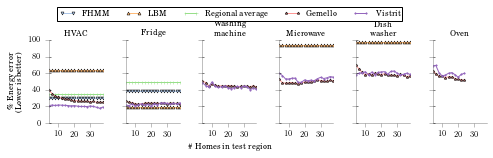

In [33]:
test_region='Austin'
appliances = ["hvac","fridge","wm","mw","dw","oven"]
#appliances=['hvac','fridge','wm']
latexify(columns=2, fig_width=6.9, fig_height=2.05)
ncols=6
fig, ax = plt.subplots(ncols=ncols, sharex=True, sharey=True)
for i, appliance in enumerate(appliances):
    print appliance
    
    
    kdd_df, kdd_err = get_kdd(appliance,params[appliance]['kdd'])
    """
    
    if appliance=="hvac":
        kdd_df = get_kdd_percentage('hvac',params['hvac']['kdd'])

    else:
        kdd_df = get_kdd(appliance,params[appliance]['kdd'])
    """
    #kdd_df.plot(label="Gemello",color=tableau20blind[6], ax=ax[i], yerr=kdd_err)
    
    fhmm_val = get_fhmm(appliance)
    fhmm_ser = pd.Series(fhmm_val, index=kdd_df.index)
    fhmm_ser.plot(label="FHMM",color=tableau20blind[1], ax=ax[i],marker='v',markersize=3)
    lbm_val = get_lbm(appliance, 'Austin')
    lbm_ser = pd.Series(lbm_val, index=kdd_df.index)
    lbm_ser.plot(label='LBM',color=tableau20blind[3],ax=ax[i],marker='^',markersize=3)
    try:
        regional_average_val = get_regional_average(appliance)
        regional_average_ser = pd.Series(regional_average_val, index=kdd_df.index)
        regional_average_ser.plot(label="Regional average",color=tableau20blind[5], ax=ax[i],marker='+',markersize=3)
    except Exception, e:
        print e
    kdd_df.plot(label="Gemello",color=tableau20blind[7], ax=ax[i],marker='*',markersize=3)
    ubicomp_df, ubicomp_err_df = get_ubicomp(appliance,params[appliance]['ubicomp']) 
    #ubicomp_df.plot(label="Vistrit", color=tableau20blind[8],ax = ax[i], yerr=ubicomp_err_df)
    ubicomp_df.plot(label="Vistrit", color=tableau20blind[8],ax = ax[i],marker='.',markersize=3)
    
    #plt.ylabel("\% Error in energy\n(lower is better)")
    #plt.xlabel("\#homes in test region")
    #plt.legend()
    #plt.tight_layout()
    format_axes(ax[i])
    ax[i].set_title(appliance_name_map[appliance])
    ax[i].set_ylim((0, 100))
    plt.locator_params(axis = 'x', nbins = 6)
a = ax[2].legend(ncol=5,loc='upper center', bbox_to_anchor=(0.5, 1.45))
#labels = ['Vistrit','Gemello','FHMM','Regional\naverage']
#fig.legend( a.get_lines(), labels, loc = (0.5, 0), ncol=5 )
#loc = 'upper center', bbox_to_anchor = (0,-0.1,1,1),
#            bbox_transform = plt.gcf().transFigure


ax[0].set_ylabel('\% Energy error \n(Lower is better)')
ax[2].set_xlabel('\# Homes in test region')
#fig.text(0.5, 0.04, '\# Homes in test region', ha='center')
#fig.text(0.04, 0.5, '\% Energy error \n(Lower is better)', va='center', rotation='vertical')
fig.tight_layout()

plt.savefig("/Users/nipunbatra/git/enerscale/results/result_buildsys.pdf",bbox_inches="tight")
#plt.savefig("/Users/nipunbatra/Desktop/result_buildsys.png",bbox_inches="tight")


In [160]:
fhmm_ser

4     30.132168
6     30.132168
8     30.132168
10    30.132168
12    30.132168
14    30.132168
16    30.132168
18    30.132168
20    30.132168
22    30.132168
24    30.132168
26    30.132168
28    30.132168
30    30.132168
32    30.132168
34    30.132168
36    30.132168
38    30.132168
dtype: float64

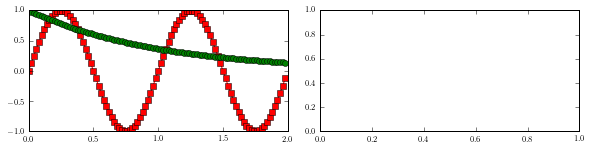

In [157]:
def get_lbm(region):
    lbm_pred_df = pickle.load(open('../data/output/lbm_15_Austin.pkl'))

In [18]:
lbm_pred_df = pickle.load(open('../data/output/lbm_15_Austin.pkl'))